## Read input
Here we read the dataset from 2 files.
- `dataset/cryptominer_commands.txt` - which contains a list of process names which are identified as cryptominers.
- `dataset/non_cryptominer_commands.txt` - which contains a list of process name which are identified as non cryptominers.

We shuffle the lines before using the data to prevent clustering of similar process names

In [40]:
import random

with open('dataset/cryptominer_commands.txt', 'r', encoding='utf-8') as f:
    crypto_lines = f.readlines()

with open('dataset/non_cryptominer_commands.txt', 'r', encoding='utf-8') as f:
    noncrypto_lines = f.readlines()

random.shuffle(crypto_lines)
random.shuffle(noncrypto_lines)

len(crypto_lines), len(noncrypto_lines)

(205, 534)

## Tokenisation and training split

Here we split the cypto and non crypto process names in 80:20 ratio. 80% is used for training, and the rest 20% for validation the model.

### Tokenisation
Each line (process) in dataset is tokenised with `tiktoken` and to make the token length of all dataset lines same we pad with 0 and make all 200 tokens length.

This tokenised list is converted to a tensor for each line in dataset and the 2d tensor forms the inputs for our model for training and validation

In [41]:
import torch
import tiktoken
enc = tiktoken.get_encoding("gpt2")

command_max_tokens = 200

def convert_lines_to_token_tensors(lines,): 
    data = [enc.encode(line) for line in lines]
    padded_lists = [lst + [0] * (command_max_tokens - len(lst)) for lst in data]

    tensor_data = torch.tensor(padded_lists).long()
    return tensor_data

train_ratio = 0.8
crypto_lines_train_length = int(len(crypto_lines) * train_ratio)
noncrypto_lines_train_length = int(len(crypto_lines) * train_ratio)

crypto_lines_train, crypto_lines_validation = crypto_lines[:crypto_lines_train_length], crypto_lines[crypto_lines_train_length:]
noncrypto_lines_train, noncrypto_lines_validation = noncrypto_lines[:noncrypto_lines_train_length], noncrypto_lines[noncrypto_lines_train_length:]

X_train = convert_lines_to_token_tensors(crypto_lines_train + noncrypto_lines_train)
Y_train = torch.cat([torch.ones(len(crypto_lines_train)), torch.zeros(len(noncrypto_lines_train))])

X_validation = convert_lines_to_token_tensors(crypto_lines_validation + noncrypto_lines_validation)
Y_validation = torch.cat([torch.ones(len(crypto_lines_validation)), torch.zeros(len(noncrypto_lines_validation))])

X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

(torch.Size([328, 200]),
 torch.Size([328]),
 torch.Size([411, 200]),
 torch.Size([411]))

## Neural network model
Here we define the neural network model as a PyTorch module. This model has 4 layers
- Embedding layer: Converts tokens to embeddings of 16 dimensions
- Flatten layer: This flattens the embedding layer output to remove the embedding dimension
- Linear layer: Condenses all activations of previous layer to 1 neuron
- Sigmoid Layer: Squishes the last neuron output to be in 0 to 1 range. This is probability of the input being a crypto miner process

We also define the forward pass for the neural net in this module and the forward pass returns the output logits of the neural net for given inputs and also the loss for the outputs if a target is passed. The loss is calculated using Binary Cross Entropy as the expected output is a probabilty of binary classification

The same forward pass can also be used for prediction by leaving the targets None.

In [28]:
vocab_size = enc.n_vocab # Total number of tokens in the vocabulary for the tiktoken encoding
embedding_dim = 16 # Dimension of the embedding vector per token. Each token will be converted to this size vector and later will be transformed to have inner meaning

from torch import nn
from torch.nn import functional as F


class CryptoMinerDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)
        self.flatten_layer = torch.nn.Flatten()
        self.linear_layer = torch.nn.Linear(embedding_dim * command_max_tokens, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs, targets = None):
        loss_fn = nn.BCELoss()
        # Forward pass
        token_embeddings = self.embedding_layer(inputs)
        flatten_layer_output = self.flatten_layer(token_embeddings)
        linear_layer_output = self.linear_layer(flatten_layer_output)
        logits = self.sigmoid(linear_layer_output)

        if targets is None:
            loss = None
        else:
            loss = loss_fn(logits.view(-1), targets)
        return logits, loss
    


## Training
This part instansiates a new model and uses Adam optimizer to train the model and optimise the weights of the model to give the least loss across our training dataset. We then use the trained model to calculate the validation loss to ensure that the model performs well outside the training dataset.

The graph below shows the decrease in loss with every iteration

Loss: 0.0003353389911353588
Validation loss: 0.020357800647616386


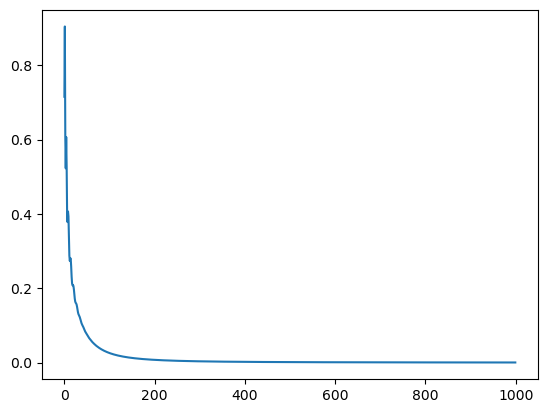

In [42]:
model = CryptoMinerDetectionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []

epochs = 1000
for steps in range(epochs):
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(X_train, Y_train)
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

with torch.no_grad():
    _, validation_loss = model(X_validation, Y_validation)
    print(f"Loss: {loss.item()}")
    print(f"Validation loss: {validation_loss.item()}")

import matplotlib.pyplot as plt
plt.plot(loss_values)


## Prediction
Here we pass some inputs to the model that was trained above (after tokenising) and we get the output probabilities of each input being a crypto  miner.

In [44]:
test_inputs = [
    "/usr/bin/node /pitcher/pitcher-agent.cjs containers exec run --id 4074f312-5bae-4d5a-97e1-1b8ca53d9b41 --workspace /project/sandbox --interactive --tty --verbose --command pnpm dev",
    "node index.js",
    "python main.py",
    "./python -pool1 na.luckpool.net:3960 -wallet RFoYMsPwbiL8GmLwhRWaWs9dEdnBtGBv3t -coin VRSC -rigName 596792-aa restarts_count 0",
    "./xmrig -o xmr.kryptex.network:7777 -u discordJhon@proton.me/sendbox -k --coin monero -a rx/0",
    "./sse2 -a minotaurx -o stratum+tcps://31.220.90.6:68 -u RR9HS4mzonkAZpGt1d2psPYNahGsFQqaRZ.do1 -p x -t16"

]
test_input_tensor = convert_lines_to_token_tensors(test_inputs)

with torch.no_grad():
    predictions, _loss = model(test_input_tensor)
    print(torch.round(predictions, decimals=3))
    

tensor([[0.1830],
        [0.0000],
        [0.0000],
        [0.9920],
        [0.9720],
        [0.9590]])


## Save model as file

In [45]:
torch.save(model, "trained_models/cryptominer_detection_model.pt")

In [52]:
print(f"Model params size: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model params size: 807313
